# **Projeto 1 introdução a redes neurais**

------------------------------------------------------------------------------------------------------------

## Objetivo: 

Implementar uma rede MLP, em python, sem usar pacotes prontos (e.g., Pytorch, Tensorflow, etc.)
Com a rede implementada, desenvolver dois modelos: um para classificação e um para regressão.
Avaliar os hiperparâmetros dos modelos variando o número de camadas, número de neurônio e taxas (eta e momentum).

## Importanto as bibliotecas necessárias

In [20]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set(
    style='darkgrid',
    context='notebook',
    rc={
        'axes.spines.top': False,
        'axes.spines.right': False
    }
)

## Funções de ativação 

A função sigmoid logística retorna 
$$
f(x) = \frac{1}{1 + \exp(-x)}
$$

In [21]:
def sigmoid(x):
    return np.where(x >= 0, 
                    1 / (1 + np.exp(-x)), 
                    np.exp(x) / (1 + np.exp(x)))

A derivada da função sigmoid retorna 

$$
f'(x) = f(x) \cdot (1 - f(x))
$$

In [22]:
def sigmoid_derivada(x): 
    return x * (1 - x)

A função softmax converte a saída padrão em uma distribuição de probabilidade, da forma: 
$$
f(y) = \frac{\exp(y)}{\sum_{k} \exp(y_k)}
$$

In [23]:
def softmax(x): 
    x = x - np.max(x, axis=-1, keepdims=True)
    exp = np.exp(x)
    return exp / np.sum(exp, axis=-1, keepdims=True)

## Retropropagação

A retropropagação surgiu para resolver o problema de como atualizar os neurônios das camadas ocultas em redes neurais. Em redes profundas, esses neurônios não têm erros diretamente observáveis como na camada de saída. O objetivo da retropropagação é calcular esses erros e ajustar os pesos das camadas ocultas utilizando o método de gradiente descendente, permitindo que redes com múltiplas camadas aprendam de forma eficiente. As contas da retropropagação envolvem o cálculo do gradiente da função de erro em relação aos pesos, ajustando-os de forma iterativa para minimizar a diferença entre as saídas desejadas e as reais. Esses cálculos incluem a atualização dos pesos na camada de saída, com base no erro direto, e nas camadas ocultas, com base nos erros propagados pela rede, até a camada de entrada. O processo é feito usando o gradiente local, o qual depende da função de ativação de cada neurônio, garantindo que o erro seja distribuído corretamente entre as camadas da rede.

### A fórmula para a atualização dos pesos de um neurônio, é dada por:
$$
\Delta w_{kj} = \eta \cdot \delta_k \cdot x_j
$$

- Onde: 
    - $\eta$ é a taxa de aprendizado
    - $\delta_k$ é o gradiente local do neurônio $k$
    - $x_j$ é a saída do neurônio anterior $j$ (entrada para o neurônio $k$)

### O cálculo do gradiente local ($\delta_k$) é dado por dois casos: 

#### Neurônio de saída: 
$
\delta_k = e_k \cdot f'(v_k)
$
- Onde:
  - $\delta_k$: Gradiente local do neurônio $k$
  - $e_k$: Erro no neurônio de saída
  - $f'(v_k)$: Derivada da função de ativação com relação ao estado interno $v_k$


#### Caso 2: Neurônio oculto: 
$
\delta_j = f'(v_j) \cdot \sum_k \delta_k \cdot w_{kj}
$

- Onde:
  - $\delta_j$: Gradiente local do neurônio $j$ da camada oculta
  - $f'(v_j)$: Derivada da função de ativação com relação ao estado interno $v_j$
  - $\sum_k$: Soma sobre todos os neurônios $k$ da camada seguinte
  - $\delta_k$: Gradiente local do neurônio $k$ da camada seguinte
  - $w_{kj}$: Peso entre o neurônio $j$ da camada oculta e o neurônio $k$ da camada seguinte



### A fórmula de erro quadrático médio ou MSE, é dada por: 

$$
E(n) = \frac{1}{2} \sum_{k} \left( d_k(n) - y_k(n) \right)^2
$$

Onde: 
- $E(n)$ é a função de erro na época $n$.
- $d_k(n)$ é o valor desejado para o neurônio $k$ na época $n$.
- $y_k(n)$ é o valor atual da saída do neurônio $k$ na época $n$.
- A soma é realizada sobre todos os neurônios $k$ da camada de saída.

### Feedfoward e Feedback 


O algoritmo de retropropagação opera em duas fases principais. Na fase de feedforward, os dados de entrada percorrem a rede camada por camada até a saída, produzindo as previsões. Já na fase de feedback, os erros calculados na saída são propagados de volta, ajustando os pesos camada a camada. Esse processo possibilita calcular o gradiente dos neurônios ocultos e atualizar seus pesos.

### Pseudocódigo 

- **Inicialização**: Configure os hiperparâmetros (taxa de aprendizado, número máximo de épocas, etc.) e inicialize os pesos da rede.
- **Treinamento**: Repita os passos abaixo até que o erro seja menor ou igual à tolerância definida ou até atingir o número máximo de épocas:
   - Aplique um padrão de entrada $x_i$ e o respectivo vetor de saída desejado $d_i$.
   - Realize a **propagação do sinal** (*feedforward*) da entrada até a saída.
   - Execute a **retropropagação dos erros** da saída para as camadas anteriores.
   - Atualize os pesos da rede com base nos gradientes calculados.
   - Retorne ao passo inicial para o próximo padrão de entrada.

### Implementação 

In [24]:
def retropropagação(X, y, pesos, bias, taxa_de_aprendizado, momentum, tipo):
    """
    Parâmetros:
    X: Dados de entrada 
    y: Valores de saída
    pesos: Lista de matrizes de pesos
    bias: Lista de vetores de bias 
    taxa_de_aprendizado: Taxa de aprendizado para atualização dos pesos
    momentum: Fator de momentum 

    Retorno:
    pesos: Pesos atualizados
    bias: Bias atualizados
    """
    ativações = [X]  # Lista para armazenar as ativações das camadas
    saídas = []  # Lista para armazenar as saídas das camadas
    
    # Feedforward: Propaga as ativações pela rede
    for i in range(len(pesos)):
        w = np.dot(ativações[-1], pesos[i]) + bias[i]  # Soma ponderada (inclui o bias)
        if i == len(pesos) - 1:
            if tipo == 'classificacao':
                # Para a camada de saída softmax
                a = softmax(w)
            elif tipo == 'regressao':
            # Para regressão, não usa softmax, a ativação é linear (sem alteração)               
                a = w
        else: 
        # Para as camadas intermediárias softmax  
            a = softmax(w)

        saídas.append(a)
        ativações.append(a)
    
    # Calcula o erro da camada de saída
    erro_saida = saídas[-1] - y  # erro da saída
    gradiente = erro_saida
    
    # Inicializa as listas de gradientes
    gradientes_pesos = []
    gradientes_bias = []
    
    # Retropropagação: Calcula os gradientes para as camadas internas
    for i in range(len(pesos)-1, -1, -1):  # Começando pela última camada (saída)
        if i == len(pesos) - 1:
            # Gradiente da camada de saída
            gradiente_w = np.dot(ativações[i].T, gradiente)  # Gradiente dos pesos da camada de saída
            gradiente_bias_i = np.sum(gradiente, axis=0)  # Gradiente dos bias da camada de saída
        else:
            # Gradiente das camadas ocultas
            gradiente = np.dot(gradiente, pesos[i + 1].T) * sigmoid_derivada(saídas[i])  # Propagação do gradiente
            gradiente_w = np.dot(ativações[i].T, gradiente)  # Gradiente dos pesos da camada oculta
            gradiente_bias_i = np.sum(gradiente, axis=0)  # Gradiente dos bias da camada oculta
        
        # Armazena os gradientes
        gradientes_pesos.append(gradiente_w)
        gradientes_bias.append(gradiente_bias_i)
    
    # Atualiza os pesos e bias com momentum
    for i in range(len(pesos)):
        # Inverte a ordem dos gradientes, pois a retropropagação percorre as camadas de trás para frente
        gradiente_w = gradientes_pesos[len(pesos)-1-i]
        gradiente_bias_i = gradientes_bias[len(pesos)-1-i]
        
        # Atualiza os pesos com a taxa de aprendizado e momentum
        pesos[i] -= taxa_de_aprendizado * gradiente_w
        bias[i] -= taxa_de_aprendizado * gradiente_bias_i  # Atualiza o bias
        
        # A forma do gradiente de bias deve ser compatível com a forma do bias[i]
        bias[i] = bias[i].reshape(gradiente_bias_i.shape)  # Ajusta o formato do gradiente para o bias
        
    return pesos, bias

## Inicialização dos pesos

In [25]:
def inicializar_pesos(tamanho_camadas): 
    """
    Inicializa os pesos e os bias de uma rede neural   
    
    Parâmetros: 
    tamanho_camadas: contém o número de neurônios em cada camada da rede
    
    Retorna: 
    pesos: lista de matrizes de pesos entre cada camada
    bias: lista de vetores de bias para cada camada
    """
    # Listas para armazenar os pesos e bias de cada camada
    pesos = []  # Lista para armazenar os pesos
    bias = []   # Lista para armazenar os bias

    for i in range(len(tamanho_camadas) - 1): 
        camada_entrada = tamanho_camadas[i]
        camada_saida = tamanho_camadas[i + 1]

        # Inicializa pesos e bias com a inicialização xavier
        peso = np.random.randn(camada_entrada, camada_saida) * np.sqrt(1 / camada_entrada)
        bias_camada = np.zeros((1, camada_saida))

        # Adiciona na lista
        pesos.append(peso)
        bias.append(bias_camada)

    return pesos, bias


## Treinamento

In [26]:
def treinamento(X_treino, y_treino, arquitetura, taxa_de_aprendizado, momentum, epocas, tipo): 
    """ 
    Parâmetros: 
    - X_treino: Matriz de entradas de treinamento    
    - y_treino: Vetor de saídas de treinamento
    - arquitetura: Lista com o número de neurônios por camada
    - taxa_de_aprendizado: Taxa de aprendizado (eta)
    - momentum: Fator de momentum
    - epocas: Número de épocas para treinamento
    
    Retorna: 
    - pesos: Pesos treinados pela rede
    - bias: Bias treinados pela rede
    - erros: Lista contendo o erro por época
    """

    # Inicializar pesos e bias
    pesos, bias = inicializar_pesos(arquitetura)

    erros = []  # Lista para armazenar os erros quadráticos médios (MSE)

    # Loop de treinamento
    for epoca in range(epocas): 
        # Atualizar pesos e bias com retropropagação
        pesos, bias = retropropagação(X_treino, y_treino, pesos, bias, taxa_de_aprendizado, momentum, tipo)

        # Calcular o erro 
        camada_de_saida = X_treino
        for peso, bias_camada in zip(pesos, bias): 
            camada_de_saida = sigmoid(np.dot(camada_de_saida, peso) + bias_camada)  # Feedforward

        erro = np.mean((y_treino - camada_de_saida) ** 2)  # Erro quadrático médio (MSE)
        erros.append(erro)  # Armazena o erro da época

    return pesos, bias, erros

## Classe MLP

In [27]:
class MLP: 
    def __init__(self, tamanho_camadas, taxa_de_aprendizado, momentum, tipo): 
        """
        Inicializa a rede neural MLP
        
        Parâmetros:
        tamanho_camadas: lista com o número de neurônios em cada camada
        taxa_de_aprendizado: taxa de aprendizado (eta)
        momentum: fator de momentum
        """
        self.tamanho_camadas = tamanho_camadas
        self.taxa_de_aprendizado = taxa_de_aprendizado
        self.momentum = momentum
        self.tipo = tipo  # Define se o modelo é para classificação ou regressão
        self.pesos, self.bias = inicializar_pesos(tamanho_camadas)


    def treinar(self, X_treino, y_treino, epocas, tipo): 
        """
        Treina o modelo usando retropropagação
        
        Parâmetros:
        X_treino: matriz de entradas de treinamento
        y_treino: vetor de saídas de treinamento
        epocas: número de épocas para treinamento
        
        Retorna:
        pesos: pesos treinados pela rede
        bias: bias treinados pela rede
        erros: lista de erros quadráticos médios por época
        """ 
        # Treinamento com base no tipo de modelo
        if self.tipo == 'classificacao':
            y_treino = np.eye(len(np.unique(y_treino)))[y_treino]  # One-hot encoding para classificação

        if self.tipo == 'regressao':       
            y_treino = y_treino.reshape(-1, 1) # Garantindo que y_treino seja uma coluna

        # Chamando a função de treinamento
        pesos, bias, erros = treinamento(X_treino, y_treino, self.tamanho_camadas, self.taxa_de_aprendizado, self.momentum, epocas, tipo)
        self.pesos = pesos
        self.bias = bias
        return pesos, bias, erros
    
    def prever(self, X): 
        """
        Realiza a previsão usando a rede neural MLP
        
        Parâmetros:
        X: matriz de entradas para previsão
        
        Retorna:
        y_pred: previsões feitas pela rede 
        """
        camada_de_entrada = X
        for peso, bias in zip(self.pesos, self.bias): 
            camada_de_entrada = np.dot(camada_de_entrada, peso) + bias  # Feedforward

        # Para classificação, usamos np.argmax para pegar a classe com maior probabilidade
        if self.tipo == 'classificacao':
            return np.argmax(camada_de_entrada, axis=1)  # Retorna as classes preditas
        elif self.tipo == 'regressao':
            return camada_de_entrada  # Retorna o valor contínuo para regressão

## Dataset e preparação dos dados

### O Dataset Iris

O Dataset é composto por 150 amostras de flores de três espécies de íris (Iris setosa, Iris versicolor e Iris virginica), com 4 características medidas: comprimento e largura das sépalas e pétalas. É amplamente utilizado para problemas de classificação, pois suas classes são bem distribuídas e as características são simples de interpretar. A escolha desse dataset se deve à sua simplicidade, tamanho moderado e equilíbrio entre as classes, o que o torna ideal para testar diferentes algoritmos de classificação.

### `train_test_split`
A função é uma ferramenta para dividir um conjunto de dados em dois subconjuntos: treinamento e teste.Ela permite que os dados sejam aleatoriamente separados, garantindo que o modelo seja treinado em uma parte dos dados e avaliado em outra, a função também permite definir a proporção da divisão.

### `StandardScaler`


A função é uma ferramenta usada para normalizar os dados, subtraindo a média e dividindo pelo desvio padrão. Esse processo transforma as características para terem média zero e desvio padrão igual a um.

### `accuracy_score`
A função calcula a acurácia de um modelo de classificação. Ele compara as previsões feitas pelo modelo com os valores reais do conjunto de dados, retornando a proporção de acertos. Essa métrica varia de 0 a 1, onde 1 significa 100% de acertos.

###  `PCA`
É uma técnica que reduz a dimensionalidade dos dados, mantendo a maior parte da variação. Ele transforma as variáveis originais em novos eixos, chamados componentes principais. O PCA é útil para simplificar a análise de dados e melhorar a visualização.

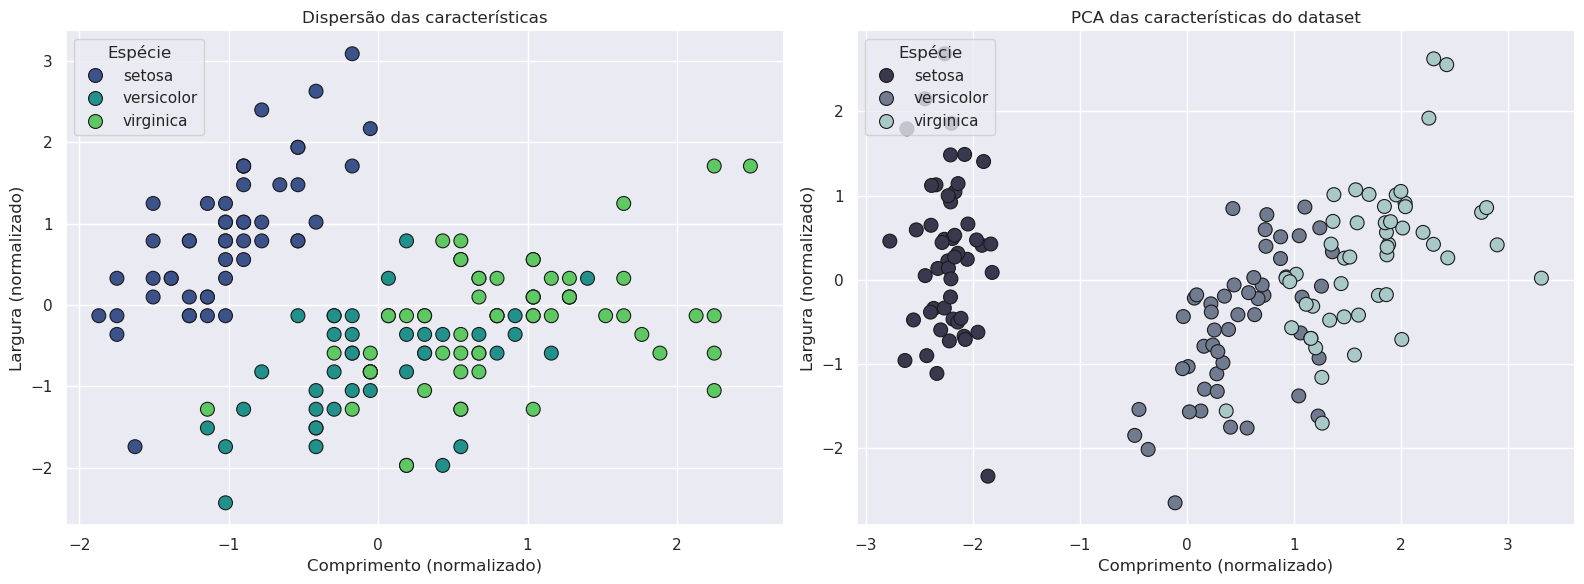

<Figure size 2000x2000 with 0 Axes>

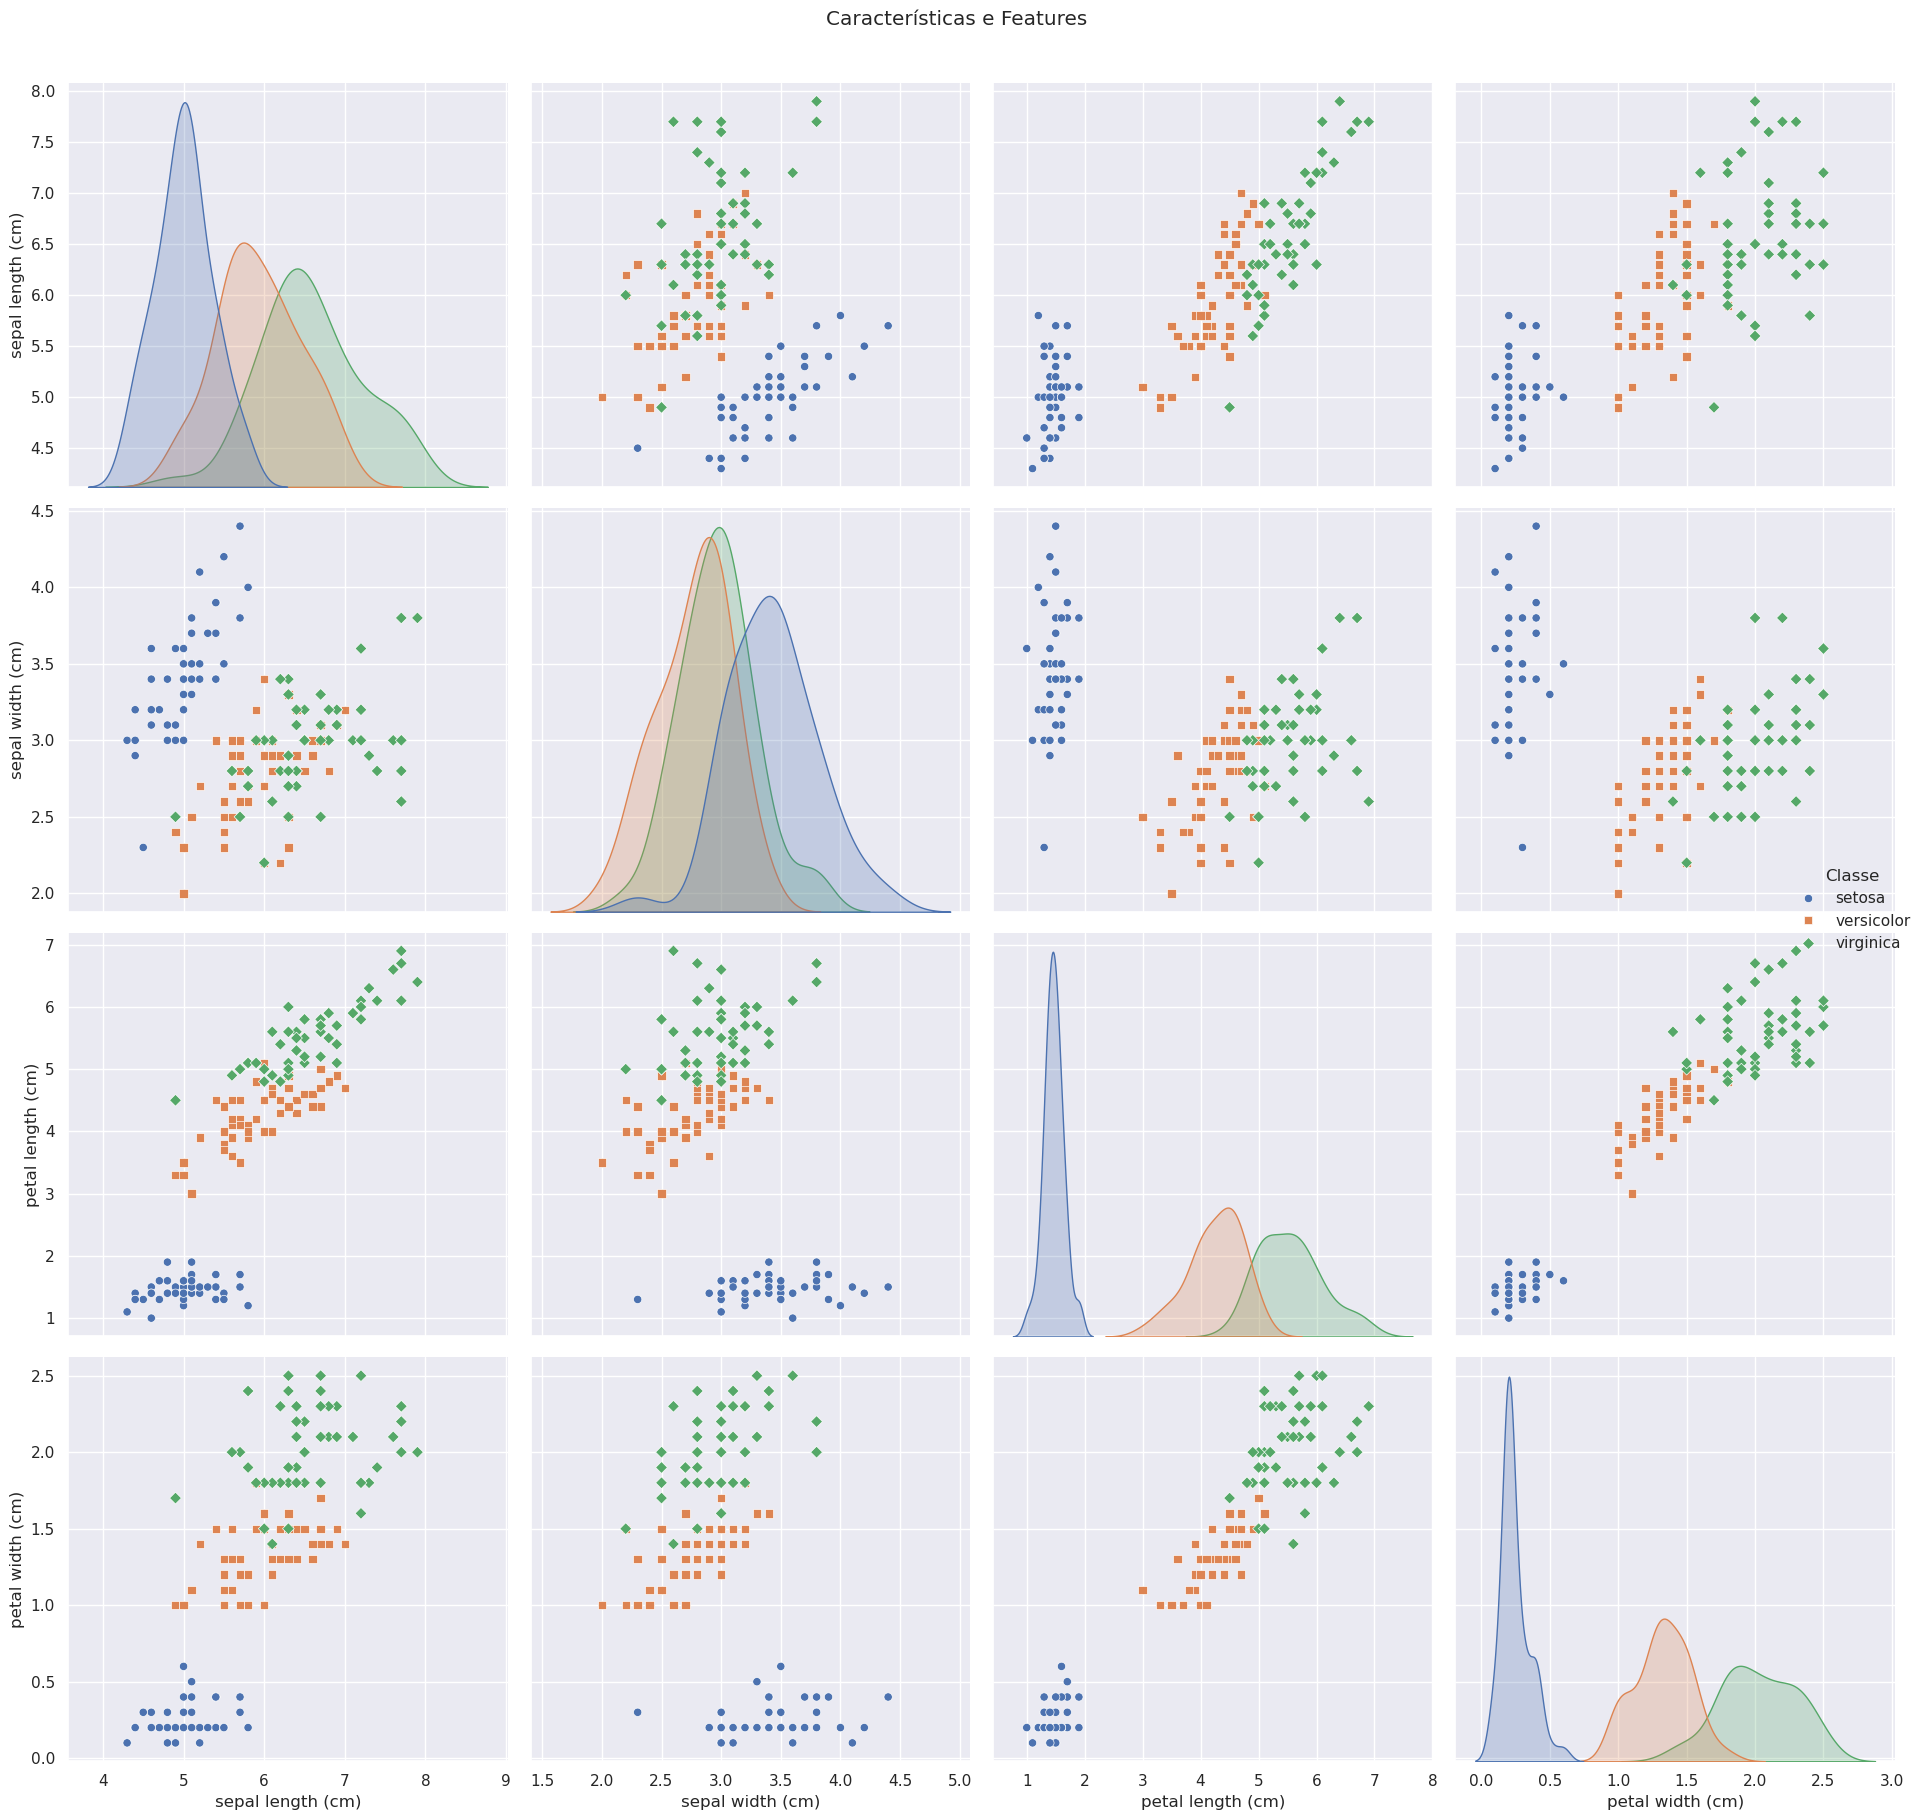

In [28]:
from sklearn.datasets import load_iris # Importando o Dataset 
from sklearn.model_selection import train_test_split # Importando train_test_split
from sklearn.preprocessing import StandardScaler # Importando StandardScaler
from sklearn.metrics import accuracy_score # Importando accuracy_score
from sklearn.decomposition import PCA # Importando PCA

# Carregar o dataset Iris
iris = load_iris()
X = iris.data  # features
y = iris.target  # target
features = iris.feature_names

# Normalizando os dados usando o StandardScaler
scaler = StandardScaler()
X_normalizado = scaler.fit_transform(X)

# Nomes das classes
y_nomes = [iris.target_names[i] for i in y]

# Visualização dos dados
_, plot = plt.subplots(1,2, figsize=(16,6))
sns.scatterplot(x=X_normalizado[:, 0], y=X_normalizado[:, 1], hue=y_nomes, palette="viridis", s=100, edgecolor='k', ax=plot[0])
plot[0].set_title('Dispersão das características')
plot[0].set_xlabel('Comprimento (normalizado)')
plot[0].set_ylabel('Largura (normalizado)')
plot[0].legend(title='Espécie', loc='upper left')

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalizado)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_nomes, palette="bone", s=100, edgecolor='k', ax=plot[1])
plot[1].set_title('PCA das características do dataset')
plot[1].set_xlabel('Comprimento (normalizado)')
plot[1].set_ylabel('Largura (normalizado)')
plot[1].legend(title='Espécie', loc='upper left')
plt.tight_layout()

plt.figure(figsize=(20, 20))
df_features = pd.DataFrame(X, columns=features)
df_features['Classe'] = y_nomes
sns.pairplot(df_features, hue='Classe', palette='deep',  markers=["o", "s", "D"], height=4.5)
plt.suptitle('Características e Features',  y=1.01)
plt.tight_layout()

## Modelo de classificação

### Primeiro modelo

O primeiro modelo foi configurado com uma rede neural MLP composta por 3 camadas: a camada de entrada possui 4 neurônios, a camada oculta tem 2 neurônios e a camada de saída possui 3 neurônios. A taxa de aprendizado foi definida como 10 e o momentum foi configurado em 0.3. O modelo foi treinado por 50 épocas

In [29]:
# Divisão dos dados de treino/teste(70/30)
X_treino, X_teste, y_treino, y_teste = train_test_split(X_normalizado, y, test_size=0.3)

/tmp/ipykernel_9862/1550035302.py:3: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-x)),
/tmp/ipykernel_9862/1550035302.py:4: RuntimeWarning: overflow encountered in exp
  np.exp(x) / (1 + np.exp(x)))
/tmp/ipykernel_9862/1550035302.py:4: RuntimeWarning: invalid value encountered in divide
  np.exp(x) / (1 + np.exp(x)))


0.4


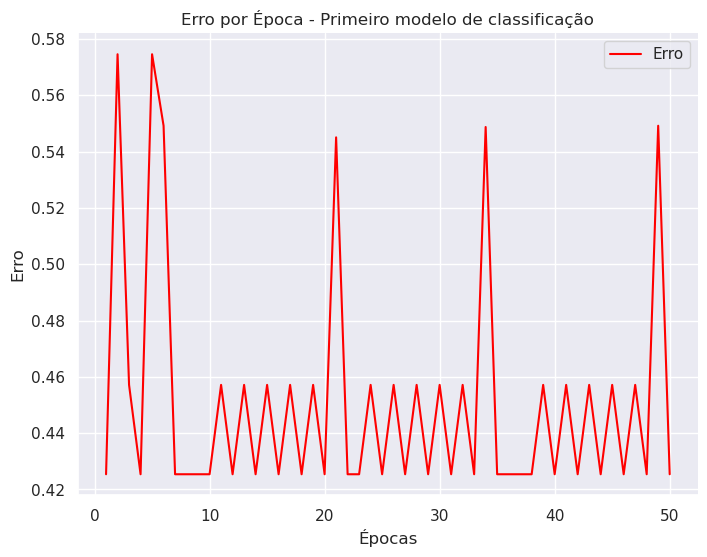

In [30]:
# Configuração do primeiro modelo
primeiro_modelo = MLP(tamanho_camadas=[4, 2, 3], taxa_de_aprendizado=10, momentum=0.3, tipo='classificacao')

# Treinamento do modelo 
pesos, bias, erros = primeiro_modelo.treinar(X_treino, y_treino, epocas=50, tipo='classificacao')

# Previsões
y_pred = primeiro_modelo.prever(X_teste)

# Acurácia
acuracia = accuracy_score(y_teste, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(erros) + 1), erros, color='red', label="Erro")
plt.title("Erro por Época - Primeiro modelo de classificação")
plt.xlabel("Épocas")
plt.ylabel("Erro")
plt.legend()
plt.grid(True)

print(acuracia)

O modelo possui uma configuração com uma taxa de aprendizado muito alta (10), o que pode causar oscilações no treinamento. A escolha de uma camada oculta com apenas 2 neurônios também limita a capacidade de aprendizado da rede. Com um número insuficiente de neurônios na camada oculta e a taxa de aprendizado elevada, o modelo não aprende de forma eficaz, resultando em uma acurácia baixa.

### Segundo modelo

O segundo modelo é uma rede neural MLP com 3 camadas: 4 neurônios na entrada, 2 na camada oculta e 3 na saída. A taxa de aprendizado foi configurada como 0.8 e o momentum em 0.6, com treinamento por 50 épocas

0.7777777777777778


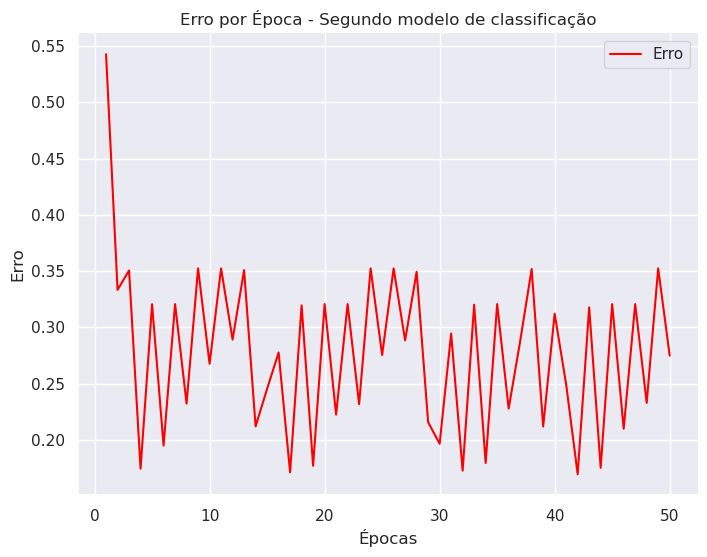

In [31]:
# Configuração do segundo modelo
segundo_modelo = MLP(tamanho_camadas=[4, 2, 3], taxa_de_aprendizado=0.8, momentum=0.6, tipo='classificacao')

# Treinamento do modelo 
pesos, bias, erros = segundo_modelo.treinar(X_treino, y_treino, epocas=50, tipo='classificacao')

# Previsões
y_pred = segundo_modelo.prever(X_teste)

# Acurácia
acuracia = accuracy_score(y_teste, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(erros) + 1), erros, color='red', label="Erro")
plt.title("Erro por Época - Segundo modelo de classificação")
plt.xlabel("Épocas")
plt.ylabel("Erro")
plt.legend()
plt.grid(True)

print(acuracia)

O modelo melhorou, alcançando uma acurácia média, graças à taxa de aprendizado de 0.8 e momentum de 0.6, que ajudaram no ajuste dos pesos. No entanto, a configuração ainda não é ideal, pois a taxa de aprendizado pode causar oscilações, e o número de neurônios na camada oculta (2) é baixo, o que limita o desempenho

### Terceiro modelo

O terceiro_modelo foi configurado com 4 neurônios na camada de entrada, 10 na camada oculta e 3 na camada de saída. A taxa de aprendizado foi ajustada para 0.05, e o momentum para 0.9. O modelo foi treinado por 200 épocas 

0.9777777777777777


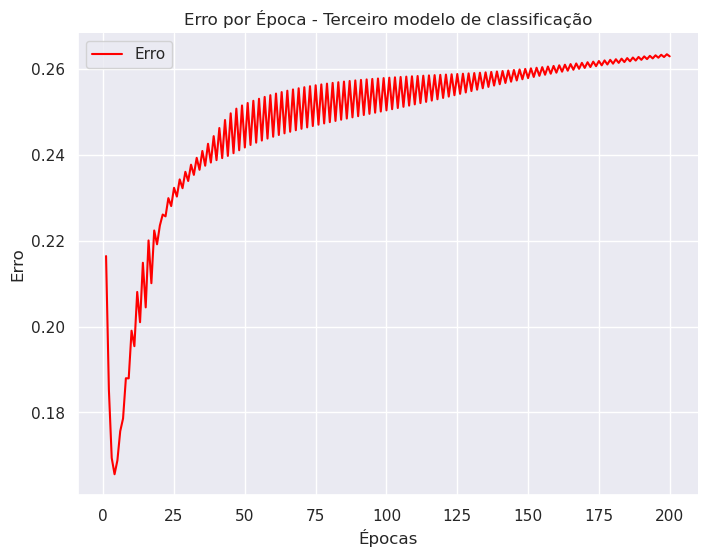

In [32]:
# Configuração do terceiro modelo
terceiro_modelo = MLP(tamanho_camadas=[4, 10, 3], taxa_de_aprendizado=0.05, momentum=0.9, tipo='classificacao')

# Treinamento do modelo 
pesos, bias, erros = terceiro_modelo.treinar(X_treino, y_treino, epocas=200, tipo='classificacao')

# Previsões
y_pred = terceiro_modelo.prever(X_teste)

# Acurácia
acuracia = accuracy_score(y_teste, y_pred)

# Plotando o gráfico de erro por época
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(erros) + 1), erros, color='red', label="Erro")
plt.title("Erro por Época - Terceiro modelo de classificação")
plt.xlabel("Épocas")
plt.ylabel("Erro")
plt.legend()
plt.grid(True)

print(acuracia)

A taxa de aprendizado foi reduzida para 0.05 e o momentum aumentou para 0.9, o que ajudou a estabilizar o treinamento. A camada oculta com 10 neurônios permitiu um melhor aprendizado. Essas mudanças resultaram em uma melhora significativa da acurácia

## Modelo de regressão

O dataset foi criado para a regressão foi feito usando `numpy` simulando $y = x$, com valores de $X$ entre 0 e 30 e ruído aleatório adicionado para gerar variações, além disso foi usado o `np.ramdom.seed` para garantir a reprodutibilidade

Além disso foi usado o erro quadrático médio ou MSE para medir o erro da regressão, que tem a fórmula dada por: 

$$
E(n) = \frac{1}{2} \sum_{k} \left( d_k(n) - y_k(n) \right)^2
$$

Onde: 
- $E(n)$ é a função de erro na época $n$.
- $d_k(n)$ é o valor desejado para o neurônio $k$ na época $n$.
- $y_k(n)$ é o valor atual da saída do neurônio $k$ na época $n$.
- A soma é realizada sobre todos os neurônios $k$ da camada de saída.

Por fim foi usado o `MinMaxScaler` que realiza a normalização dos dados, escalando seus valores para um intervalo específico. A fórmula é:

$$
X_{\text{escalado}} = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}}
$$

Aqui:

- $X$ é o valor original do dado.
- $X_{\text{min}}$ e $X_{\text{max}}$ são, respectivamente, o menor e o maior valor da feature.
- $X_{\text{escalado}}$ é o valor normalizado.

### Preparação dos dados

In [33]:
from sklearn.metrics import mean_squared_error # Importando o MSE

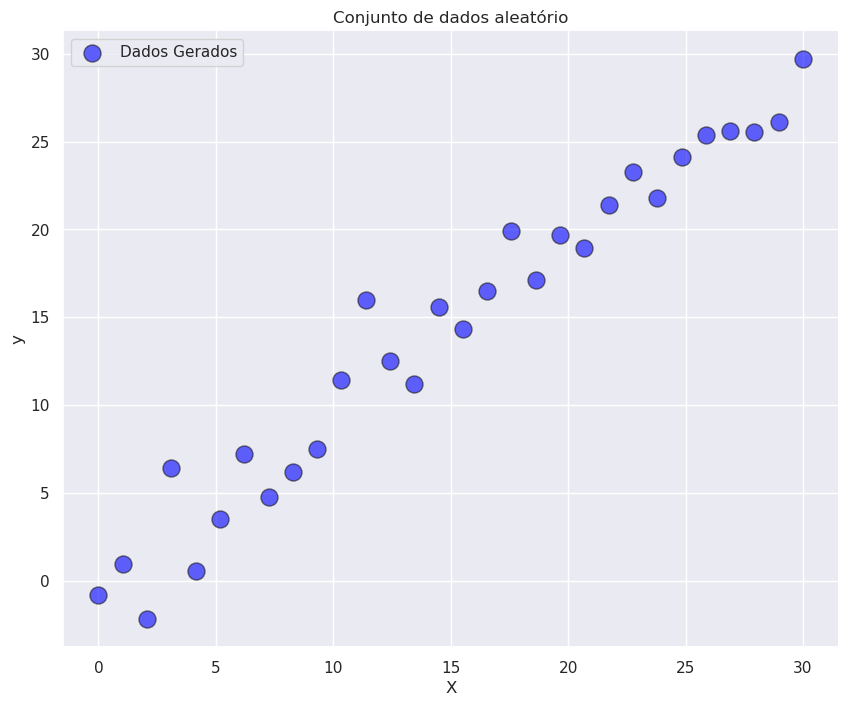

In [34]:
# Gerando pontos

np.random.seed(2)
X_aleatorio = np.linspace(0, 30, 30).reshape(-1, 1)

# Gerando y = x + ruído
y_aleatorio = X_aleatorio.flatten() + np.random.normal(scale=2, size=X_aleatorio.shape[0])  

# Plotando os dados
plt.figure(figsize=(10, 8))
plt.scatter(X_aleatorio, y_aleatorio, color='blue', edgecolor='k', s=150, alpha=0.6, label='Dados Gerados')
plt.title("Conjunto de dados aleatório")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.grid(True)

In [35]:
from sklearn.preprocessing import MinMaxScaler # Importando o MinMaxScaler

#Normalizando os dados
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_aleatorio_normalizado = scaler_X.fit_transform(X_aleatorio)
y_aleatorio_normalizado = scaler_y.fit_transform(y_aleatorio.reshape(-1, 1)).flatten()

### Primeiro modelo

O primeiro modelo de regressão foi configurado com uma rede neural MLP composta por 3 camadas: a camada de entrada possui 1 neurônio, a camada oculta tem 3 neurônios e a camada de saída possui 1 neurônio. A taxa de aprendizado foi definida como 0.001 e o momentum foi configurado em 0.1. O modelo foi treinado por 50 épocas

275.2535168372561


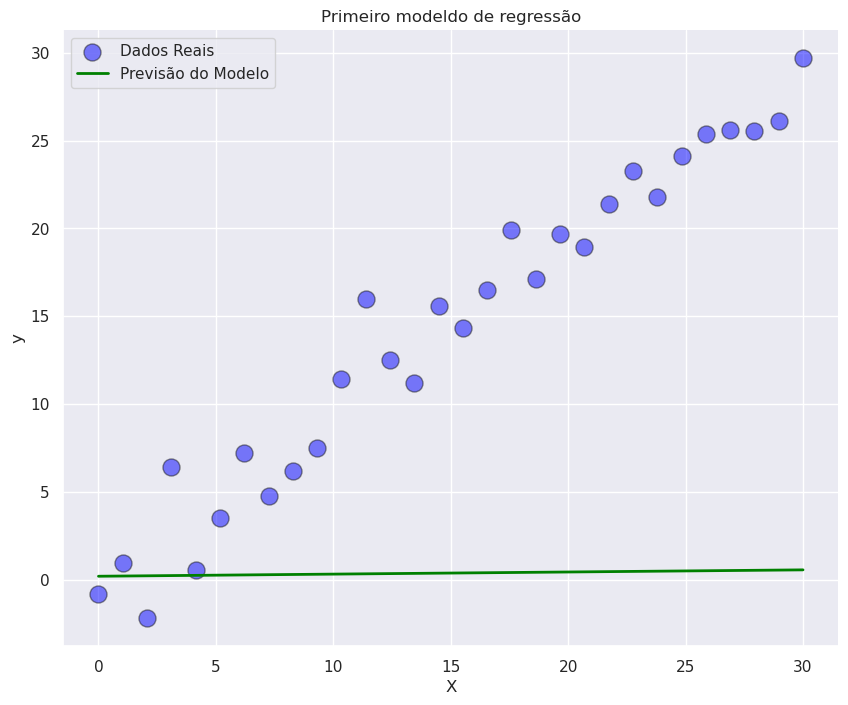

In [36]:
# Criando o primeiro modelo de regressão 
primeiro_modelo_regressao = MLP(tamanho_camadas=[1, 3, 1], taxa_de_aprendizado=0.001, momentum=0.1, tipo='regressao')

# Treinando o primeiro modelo de regressão
primeiro_modelo_regressao.treinar(X_aleatorio_normalizado, y_aleatorio_normalizado, epocas=50, tipo='regressao')

y_pred_1 = primeiro_modelo_regressao.prever(X_aleatorio_normalizado)

# Plotando a regressão
plt.figure(figsize=(10, 8))
plt.scatter(X_aleatorio, y_aleatorio, color='blue', edgecolor='k', s=150, alpha=0.5, label='Dados Reais')
plt.plot(X_aleatorio, y_pred_1, color='green', linewidth=2, label='Previsão do Modelo')
plt.title("Primeiro modeldo de regressão")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
mse = mean_squared_error(y_aleatorio, y_pred_1)
print(mse)

O modelo possui um configuração com apenas 3 neurônios na camada oculta, o que limita sua capacidade de capturar padrões nos dados. Além disso, a taxa de aprendizado muito baixa (0.001) torna o treinamento lento e dificulta um bom resultado em apenas 50 épocas

### Segundo modelo

O segundo modelo de regressão foi configurado com uma rede neural MLP composta por 3 camadas: a camada de entrada possui 1 neurônio, a camada oculta tem 10 neurônios e a camada de saída possui 1 neurônio. A taxa de aprendizado foi definida como 0.05 e o momentum foi configurado em 0.5. O modelo foi treinado por 1000 épocas

149.2097003629772


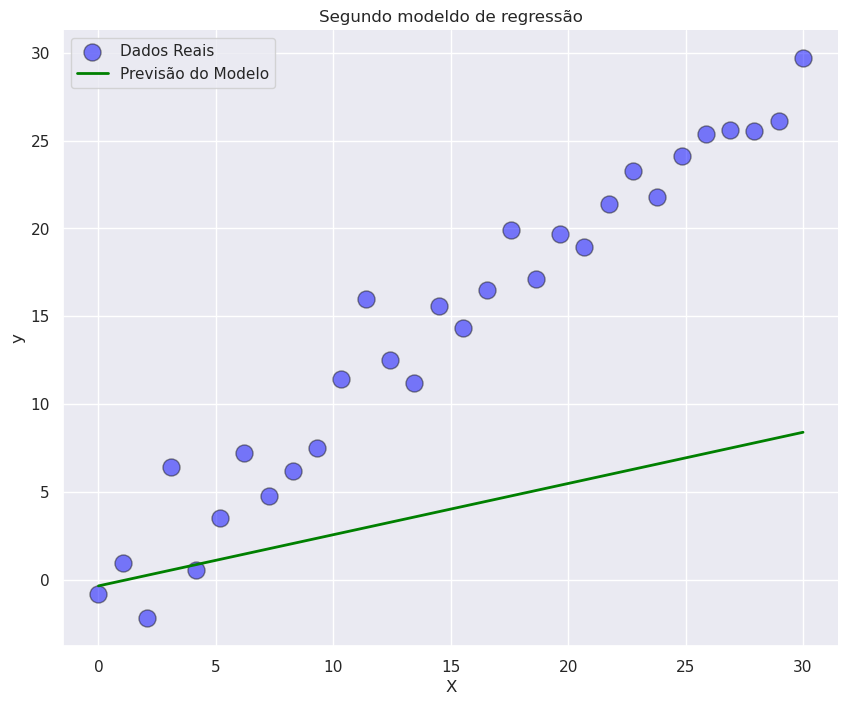

In [37]:
# Criando o segundo modelo de regressão 
segundo_modelo_regressao = MLP(tamanho_camadas=[1, 10, 1], taxa_de_aprendizado=0.05, momentum=0.5, tipo='regressao')

# Treinando o segundo modelo de regressão 
segundo_modelo_regressao.treinar(X_aleatorio_normalizado, y_aleatorio_normalizado, epocas=1000, tipo='regressao')

y_pred_2 = segundo_modelo_regressao.prever(X_aleatorio_normalizado)

# Plotando a regressão
plt.figure(figsize=(10, 8))
plt.scatter(X_aleatorio, y_aleatorio, color='blue', edgecolor='k', s=150, alpha=0.5, label='Dados Reais')
plt.plot(X_aleatorio, y_pred_2, color='green', linewidth=2, label='Previsão do Modelo')
plt.title("Segundo modeldo de regressão")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
mse = mean_squared_error(y_aleatorio, y_pred_2)
print(mse)

O segundo modelo de regressão tem um desempenho médio. Ele utiliza 10 neurônios na camada oculta, o que aumenta sua capacidade de aprendizado em comparação ao primeiro modelo. A taxa de aprendizado moderada (0.05) e o momentum de 0.5 ajudam a ajustar os pesos de forma mais estável, enquanto as 1000 épocas garantem mais iterações para o aprendizado

### Terceiro modelo

O terceiro modelo de regressão foi configurado com uma rede neural MLP composta por 4 camadas: a camada de entrada possui 1 neurônio, as camadas ocultas possuem 10 neurônios cada e a camada de saída possui 1 neurônio. A taxa de aprendizado foi definida como 0.05 e o momentum foi configurado em 0.9. O modelo foi treinado por 1000 épocas

149.2097003629772


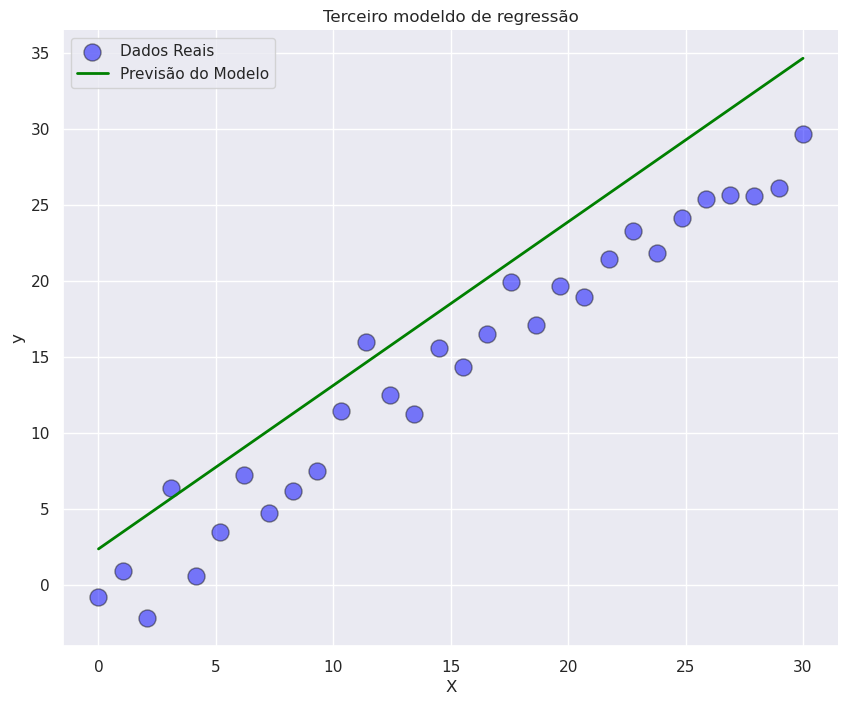

In [38]:
# Criando o terceiro modelo de regressão 
terceiro_modelo_regressao = MLP(tamanho_camadas=[1, 10, 10, 1], taxa_de_aprendizado=0.05, momentum=0.9, tipo='regressao')

# Treinando o terceiro modelo de regressão
terceiro_modelo_regressao.treinar(X_aleatorio_normalizado, y_aleatorio_normalizado, epocas=1000, tipo='regressao')

y_pred_3 = terceiro_modelo_regressao.prever(X_aleatorio_normalizado)

# Plotando a regressão
plt.figure(figsize=(10, 8))
plt.scatter(X_aleatorio, y_aleatorio, color='blue', edgecolor='k', s=150, alpha=0.5, label='Dados Reais')
plt.plot(X_aleatorio, y_pred_3, color='green', linewidth=2, label='Previsão do Modelo')
plt.title("Terceiro modeldo de regressão")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
mse = mean_squared_error(y_aleatorio, y_pred_2)
print(mse)

O terceiro modelo de regressão tem um desempenho bom. Ele utiliza 10 neurônios em cada camada oculta, o que aumenta sua capacidade de aprendizado em comparação aos outros modelo. A taxa de aprendizado moderada (0.05) e o momentum de 0.9 ajudam a ajustar os pesos de forma mais estável, enquanto as 1000 épocas garantem mais iterações para o aprendizado